In this notebook we cluster the measured target spectra for each species 


In [1]:
import time
import os.path
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from tenacity import retry, stop_after_attempt
import glob
import scipy as sc
import csaps

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from skimage import feature
from yellowbrick.cluster.elbow import kelbow_visualizer

import sys, errno  


In [2]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

In [3]:

palette = sns.color_palette('Paired', n_colors=14)
plt.style.use(['seaborn-colorblind'])
plt.rc('font', family='Arial')
SMALL_SIZE = 12
BIGGER_SIZE = 14
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['xtick.direction'] = 'inout'
plt.rcParams['ytick.direction'] = 'inout'
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['ytick.major.width'] = 1

savefigs_path = 'C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/AFKABAN'

In [4]:
# -- USER-DETERMINED PARAMETERS -----------------------------------------------
letter_drive = 'F'
ppath = f'{letter_drive}:/AFKABAN/Pcod_190123/'
p2path = f'{letter_drive}:/AFKABAN/Pcod2_240123/'
apath = f'{letter_drive}:/AFKABAN/Acod_200123/'
pbpath = f'{letter_drive}:/AFKABAN/Pandalus_260123/'


# Read saved df

In [5]:
a_df = pd.read_feather(apath+'/a_tilt_df.feather')
p_df = pd.read_feather(ppath+'/p_tilt_df.feather')
p2_df = pd.read_feather(p2path+'/p2_tilt_df.feather')
pb_df = pd.read_feather(pbpath+'/pb_tilt_df.feather')


# Cluster spectra
sort by frequency bandwith

In [6]:
def select_ts_bandwidth(df):
    'Function to seperated target spectra from 120 kHz and 200 kHz echosounders'
    ind_120 = np.where(df['200.000']<-9999)[0]
    ts_s_120 = np.where(df.columns.values=='90.000')[0][0]
    ts_e_120 = np.where(df.columns.values=='162.000')[0][0]
    
    ind_200 = np.where(df['120.000']<-9999)[0]
    ts_s_200 = np.where(df.columns.values=='185.000')[0][0]
    ts_e_200 = np.where(df.columns.values=='255.000')[0][0]

    df_120 = df.iloc[ind_120,ts_s_120:ts_e_120]
    df_200 = df.iloc[ind_200,ts_s_200:ts_e_200]
    
    return df_120, df_200

In [7]:
a_df_120, a_df_200 = select_ts_bandwidth(a_df)
p_df_120, p_df_200 = select_ts_bandwidth(p_df)
p2_df_120, p2_df_200 = select_ts_bandwidth(p2_df)
pb_df_120, pb_df_200 = select_ts_bandwidth(pb_df)

### Select a df and run clustering

Normalize by the median of each target spectra

In [10]:
def kmean_spectra(df, num_clus=6):
    'Function to run kmean clusering on target spectra of a species'
    kmeans = KMeans(n_clusters=num_clus)
    df_norm = df.div(df.median(axis=1), axis=0)
    y_kmean = kmeans.fit_predict(df_norm)

    return y_kmean
    

In [15]:
num_clus=6

a_120_ykmean = kmean_spectra(a_df_120)
p_120_ykmean = kmean_spectra(p_df_120)
p2_120_ykmean = kmean_spectra(p2_df_120)


a_200_ykmean = kmean_spectra(a_df_200)
p_200_ykmean = kmean_spectra(p_df_200)
p2_200_ykmean = kmean_spectra(p2_df_200)

C:\Users\mbd\anaconda3\envs\AZKABANML\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.
  warnings.warn(
C:\Users\mbd\anaconda3\envs\AZKABANML\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.
  warnings.warn(


In [16]:
# Add kmeans group to main dataframe
def add_ykmean(df, y_120, y_200, df_f120, df_f200):
    y_120 = pd.DataFrame(y_120, index=df_f120.index, columns=['y_kmean'])
    y_200 = pd.DataFrame(y_200, index=df_f200.index, columns=['y_kmean'])
    y = pd.concat([y_120,y_200])
    df['y_kmean']=y
    
    return df

In [17]:
a_df = add_ykmean(a_df, a_120_ykmean, a_200_ykmean, a_df_120, a_df_200)
p_df = add_ykmean(p_df, p_120_ykmean, p_200_ykmean, p_df_120, p_df_200)
p2_df = add_ykmean(p2_df, p2_120_ykmean, p2_200_ykmean, p2_df_120, p2_df_200)

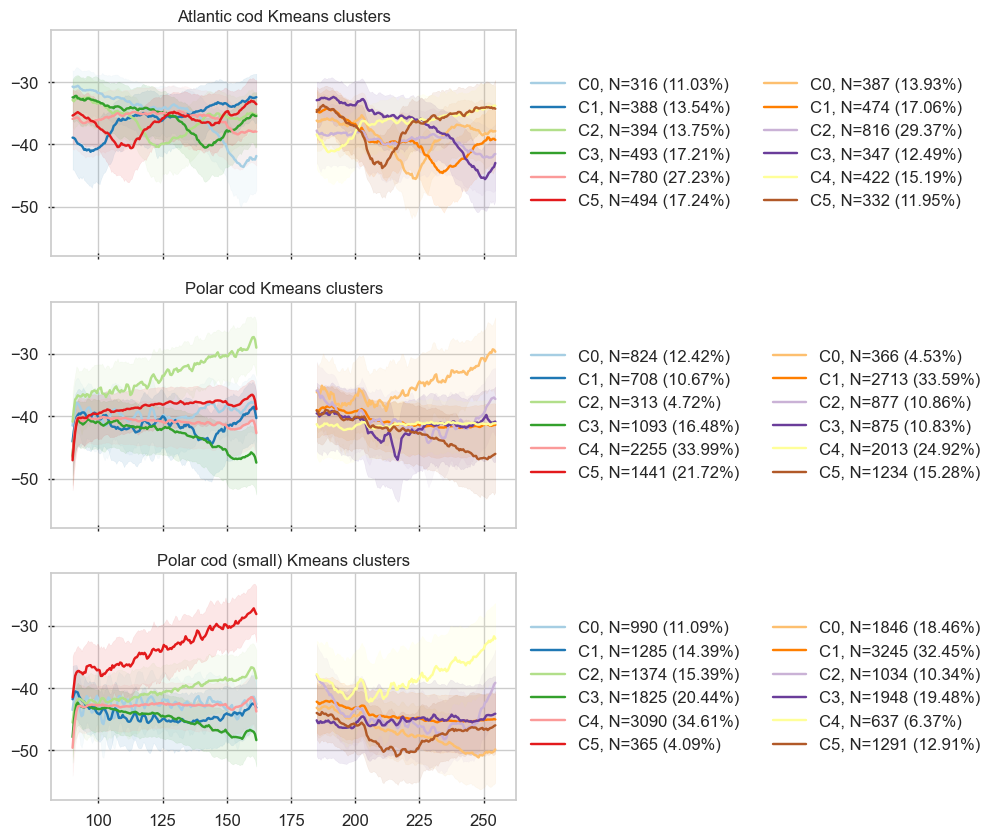

In [18]:
df_list = [a_df_120,p_df_120,p2_df_120]
y_list = [a_120_ykmean, p_120_ykmean, p2_120_ykmean]
df2_list = [a_df_200,p_df_200,p2_df_200]
y2_list = [a_200_ykmean, p_200_ykmean, p2_200_ykmean]
    
name_list = ['Atlantic cod', 'Polar cod', 'Polar cod (small)']
fig,ax = plt.subplots(3,1, figsize=(6,10), sharex=True, sharey=True)
axes = ax.flatten()

for i_df in range(len(df_list)):
    # 120 kHz
    df1 = df_list[i_df]
    y_kmean1 = y_list[i_df]
    freqs_120 = df1.columns.unique().values.astype(np.float64)

    for i_cluster in range(num_clus):
        i_ts1 = np.where(y_kmean1==i_cluster)[0]
        N1 = len(i_ts1)
        
        axes[i_df].plot(freqs_120,np.median(df1.iloc[i_ts1,:].T,axis=1), c=palette[i_cluster], label=f'C{i_cluster}, N={N1} ({N1*100/len(df1):.2f}%)')
        axes[i_df].fill_between(freqs_120,df1.iloc[i_ts1,:].quantile(q=0.25), df1.iloc[i_ts1,:].quantile(q=0.75), color=palette[i_cluster], alpha=0.1)
        
        
    # 200 kHz
    df2 = df2_list[i_df]
    y_kmean2 = y2_list[i_df]
    freqs_200 = df2.columns.unique().values.astype(np.float64)

    for i_cluster in range(num_clus):
        i_ts2 = np.where(y_kmean2==i_cluster)[0]
        N2 = len(i_ts2) 

        axes[i_df].plot(freqs_200,np.median(df2.iloc[i_ts2,:].T,axis=1), c=palette[i_cluster+6], label=f'C{i_cluster}, N={N2} ({N2*100/len(df2):.2f}%)')
        axes[i_df].fill_between(freqs_200,df2.iloc[i_ts2,:].quantile(q=0.25), df2.iloc[i_ts2,:].quantile(q=0.75), color=palette[i_cluster+6], alpha=0.1)
        
    axes[i_df].legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)
    axes[i_df].set_title(f'{name_list[i_df]} Kmeans clusters')


Observations:
- Atlanctic cod has a larger (~5dB) dip in the traget spectra that shifts horizontally. What causes the shift?
- Polar cod (both experiments are similar, great start, has no consistent dips but positive, zero or negative slope.
- Pandalus does not have enough targets for clustering. Too much variability for the few amount of tracked detections. But Pandalus can be differentiated with a threshold

- cluster have a lot of variability!

# Can we correlate cluster number to tilt angle??

In [ ]:
t_clus = match_tilt_to_cluster(a_df,a_120_ykmean)
sns.catplot(data=a_df, x='y_kmeans', y='Region_name', kind="box")

CLuster number and orientation does not seem to be related

# Can we correlate cluster number to track number?? 
(which would mean the backscatter is related to the fish size or per fish properties

In [ ]:
t = tilt_a120.reset_index()

In [ ]:
pd.concat([t,y], axis=1)

# Storage Area

### Elbow algorithm to find optimal clusters

Run elbow algorithm for optimal number of clusters.

Optimal value is found at the "elbow" of the distortion results.

In [ ]:
#Use the quick method and immediately show the figure
df = pb_df_200
df_norm = df.div(df.median(axis=1), axis=0)
kelbow_visualizer(KMeans(), df_norm, k=(1,20))